# Micrograd

A deep dive into the heart of Neutal Network, inspired by Andrew Karpathy's yoututbe videos.


In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
import os
from graphviz import Digraph
%matplotlib inline

## The Value class

This part will focus on how calculations and backpropagations work inside a neural network.

In order to do that, a Value class is defined. 

Values will be used to make expressions and calculate gradients.

The entire class will be implemented here, but its functionalities will be used incrementally across this notebook.

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data 
        self.grad = 0.00 # gradient of this Value, used in backpropagation (how much this Value contributes to the final output)
        self._backward = lambda: None # this function will change, depending on the operation
        self._prev = set(_children) # a Value can be the result of multiple parents
        self._op = _op # the operation that produced this Value, used in visual representations
        self.label = label # a label for the node, used in visual representations
    
    def __repr__(self):
        return f"Value(data={self.data})" # printing the Value object will show the data
    
    # we need to define all the possible operations for our Value class
     
    def __add__(self, other):
        # this is done in order to add constants to Values that are not Values themselves
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, (self, other), '+')

        # += grad because this node can be used multiple times during backpropagation
        def _backward():
            self.grad += 1.0 * out.grad #(see sum example backpropagation below)
            other.grad  += 1.0 * out.grad #(see sum example backpropagation below)
        out._backward = _backward 
        return out
    
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def __mul__(self, other):
        # this is done in order to multiply constants to Values that are not Values themselves
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            # local derivative (out.grad) multiplied by other.data, as per the chain rule
            self.grad += other.data * out.grad #(see product example backpropagation below)
            other.grad  += self.data * out.grad
        out._backward = _backward
        return out 
    
    def __rmul__(self, other):
        return self * other
    
    # function called when a Value is raised to a power and other is that power
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power must be int or float, supporting only this for now"
        out = Value(self.data**other, (self,), f'pow_{other}')
        def _backward():
            self.grad += other * self.data**(other-1) * out.grad # power rule: d/dx x^n = n*x^(n-1), and then chain rule (* out.grad)
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp') # out.data used below
        def _backward():
            self.grad += out.data * out.grad # d/dx exp(x) = exp(x)
        out._backward = _backward
        return out
    
    # used inthe neuron example, as the activation function
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out =  Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        self.grad = 1.0
        visited = set()
        topo_order = []
    
        def dfs(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    dfs(child)
                topo_order.append(v)

        dfs(self)
        for v in reversed(topo_order):
            v._backward()

In [13]:
# Since __add__ and __mul__ are defined, we can now use the + and * operators on Value objects
a = Value(3)
b = Value(4)
c = a + b
d = a * b
print(f'Value results: {c, d}')

# we can also inspect the parents of a Value object and the operation that produced it
print(f'Value parents: {c._prev, d._prev}')
print(f'Value operations: {c._op, d._op}')

Value results: (Value(data=7), Value(data=12))
Value parents: ({Value(data=3), Value(data=4)}, {Value(data=3), Value(data=4)})
Value operations: ('+', '*')


## Visualization functions

In order to better represent the future operation graphs, we implement some functions using graphviz

In [14]:
def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        dot.node(name=str(id(n)), label=f"{n.label} | data {round(n.data,4)} | grad {round(n.grad, 4)}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


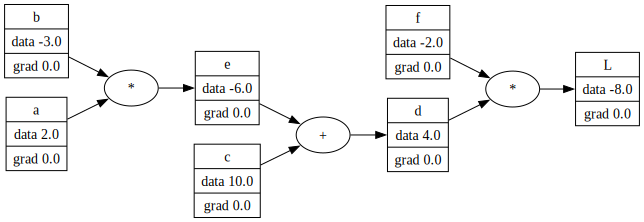

In [16]:
# Let's test the visualization

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
e = a * b; e.label = 'e'

c = Value(10.0, label='c')
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L
draw_dot(L)

## Filling up the gradients

Let's use the operation above to inspect the derivatives if the final output **L** with respect to the other Values?
- Derivative of **L** with respect to **L**: 1.0 (if I add a tiny amount to L, how much does L change? dL * h)
- Derivative of **L** with respect to **d** **(dL/dd)**: **f**, so 4.0
    - (*f*(x + h) - *f*(x)) / h -> (definition of derivative)
    - ((d + h) * f - d * f) / h (since L is d * f)
    - (d * f + h * f - d * f) / h -> (h * f) / h -> f
- Derivative of **L** with respect to **f** **(dL/df)**: d, so -2.0
- Derivative of **d** with respect to **c** **(dd/dc)**: 1.0
    - d = c + e
    - (*f*(x + h) - *f*(x)) / h ->
    - ((c + h + e) - (c + e)) / h ->
    - (c + h + e - c - e) / h -> h / h -> 1.0
- Derivative of **d** with respect to **e** **(dd/de)**: 1.0 (same as above, + operation)

In order to derive **dL/dc**, where **c** is not a direct parent of **L**, we use the **chain rule**:
#### *dz/dx* = *dz/dy* * *dy/dx*
So:
- Derivative of **L** with respect to **c** **(dL/dc)**: **(dL/dd)** * **(dd/dc)** = -2.0 * 1.0 = -2.0
- Derivative of **L** with respect to **e** **(dL/de)**: **(dL/dd)** * **(dd/de)** = -2.0 * 1.0 = -2.0
(so a + operation just 'routes' the gradient from a children to their parents)
- Derivative of **e** with respect to **a** **(de/da)**: **b**, so -3.0 (product)
- Derivative of **e** with respect to **b** **(de/db)**: **a**, so 2.0 (product)
- Derivative of **L** with respect to **a** **(dL/da)**: **(dL/de)** * **(de/da)** = -2.0 * -3.0 = 6.0
- Derivative of **L** with respect to **b** **(dL/db)**: **(dL/de)** * **(de/db)** = -2.0 * 2.0 = -4.0

So:

- L.grad = 1.0
- f.grad = 4.0 # value of d
- d.grad = -2.0 # value of f
- c.grad = -2.0 # grad of d (with a + sign you just pass the grad)
- e.grad = -2.0 # grad of d (with a + sign you just pass the grad)
- a.grad = -3.0 * -2.0 # grad of e * value of b (product)
- b.grad = 2.0 * -2.0 # grad of e * value of a (product)



## Backpropagation through a Neuron

![Neuron Diagram](./../resources/images/neuron.png)

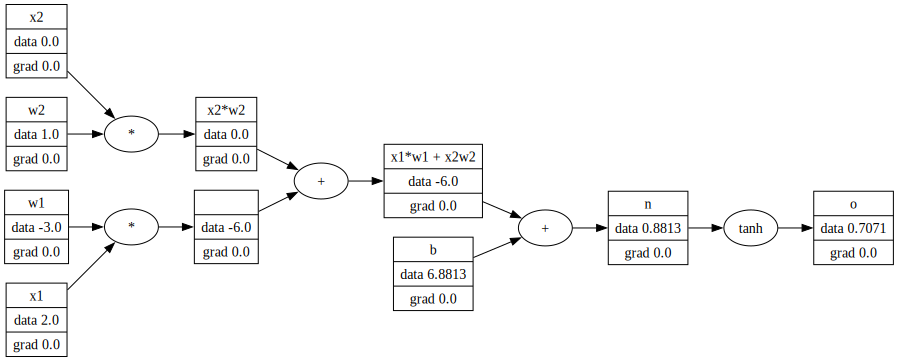

In [23]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2') 

# bias (strange value in order to have nicer number during backpropagation)
b = Value(6.8813, label='b') 

# mutiply inputs by weights
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

# add weighted inputs and bias
x1w1x2w2 = x1*w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.tanh(); o.label = 'o'

draw_dot(o)

## Filling up the gradients

We could derive the derivatives of the output with respect of every input, but we only care about the weight ones, as those derivatives/gradients will be used to modify the weights during optimization.

- Derivative of **o** with respect to **o**: 1.0 
- Derivative of **o** with respect to **n** **(do/dn)**: 1 - tanh(n)^2 -> 1 - o^2 -> 0.5 (no demonstration here)
- Derivative of **o** with respect to **x1w1x2w2** **(do/dx1w1x2w2)**:  0.5 (sum)
- Derivative of **o** with respect to **b** **(do/db)**:  0.5 (sum)
- Derivative of **o** with respect to **x1w1** **(do/dx1w1)**:  0.5 (sum)
- Derivative of **o** with respect to **x2w2** **(do/dx2w2)**:  0.5 (sum)

- Derivative of **x2** with respect to **x2w2** **(dx2w2/dx2)**: **x2w2.grad** * **w2** -> 0.5 * 1.0 = 0.5  (product)
- Derivative of **w2** with respect to **x2w2** **(dx2w2/dw2)**: **x2w2.grad** * **x2** -> 0.5 * 0.0 = 0.0  (product)

- Derivative of **x1** with respect to **x1w1** **(dx1w1/dx1)**: **x1w1.grad** * **w1** -> 0.5 * -3.0 = -1.5  (product)
- Derivative of **w1** with respect to **x1w1** **(dx1w1/dw1)**: **x1w1.grad** * **x1** -> 0.5 * 2.0 = 1.0  (product)


So:

- o.grad = 1
- n.grad = 1 - o.data^2 = 0.5


- b.grad = n.grad (sum node, just pass the grad)
- x1w1x2w2.grad = n.grad (sum node, just pass the grad)

- x1w1.grad = n.grad (sum node, just pass the grad)
- x2w2.grad = n.grad(sum node, just pass the grad)



- x1.grad = w1.data * x1w1.grad (product node, apply the chain rule)
- x2.grad = w2.data * x2w2.grad (product node, apply the chain rule)
- w1.grad = x1.data * x1w1.grad (product node, apply the chain rule)
- w2.grad = x2.data * x2w2.grad (product node, apply the chain rule)


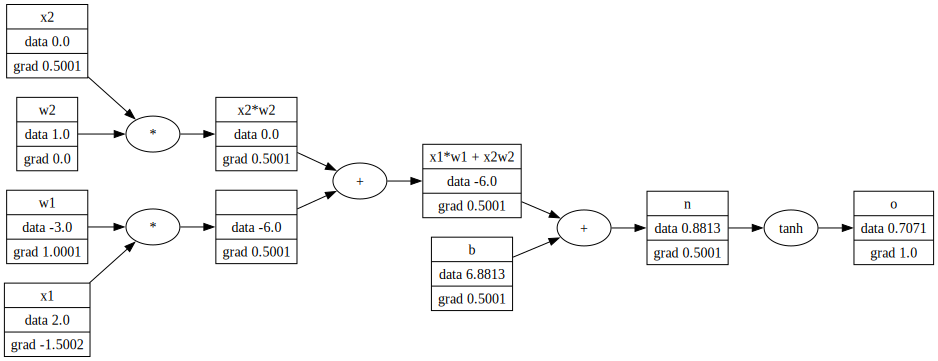

In [ ]:
# having implemented the _backward() function for every operation we can now backpropagate
# this will update the gradients of the Value objects, which will be used to update the weights and bias
# the gradients of the output nodes are set to 1.0, as the derivative of the loss with respect to itself is 1.0
# careful, we are not calling the _backward() funtion of o, but the backward() one, which will call the _backward() functions of all the nodes in the graph in topological order
o.grad = 1.0
o.backward()
draw_dot(o)